# Calculate how age and basic statistics impact wRC+
Stats: Age, wRC+, OBP, SLG, K%, BB%

In [1]:
import utils
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# load data
data = pd.read_csv('full_data.csv')

In [3]:
# get subsets of data
X = pd.DataFrame({'Age': [], 'wRC+': [], 'OBP': [], 'SLG': [], 'K%': [], 'BB%': []})
y = pd.DataFrame({'wRC+': []})

# iterate through data and connect ages and wRC+ to the following season's wRC+
for index, row in data.iterrows():
    next_year = data.loc[(data['PlayerId'] == row['PlayerId']) & (data['Season'] == row['Season'] + 1)]

    if next_year.size > 0:

        to_add_x = pd.DataFrame({'Age': [row['Age']],
                                 'wRC+': [row['wRC+']],
                                 'OBP': [row['OBP']], 
                                 'SLG': [row['SLG']], 
                                 'K%': [row['K%']],
                                 'BB%': [row['BB%']]})
        X = pd.concat([X, to_add_x], ignore_index=True)

        to_add_y = pd.DataFrame({'wRC+': next_year['wRC+']})
        y = pd.concat([y, to_add_y], ignore_index=True)

# scale X
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [4]:
# display shape of data
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (1662, 6)
Shape of y: (1662, 1)


In [5]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# convert train sets to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# convert test sets to tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [6]:
# set batch size
batch_size = 32

# create datasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# create dataloaders
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

for X, y in test_loader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([32, 6])
Shape of y: torch.Size([32, 1]) torch.float32


In [7]:
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
# define model
model = utils.RegressionModel(X.shape[1]).to(device)
print(model)

RegressionModel(
  (layer1): Linear(in_features=6, out_features=12, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=12, out_features=12, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=12, out_features=1, bias=True)
)


In [9]:
# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

Epoch 1
-------------------------------
Batch 1, Loss: 12866.9062
Batch 6, Loss: 10780.3154
Batch 11, Loss: 11077.4883
Batch 16, Loss: 10990.0723
Batch 21, Loss: 11968.1064
Batch 26, Loss: 10868.1104
Batch 31, Loss: 12098.3936
Batch 36, Loss: 11847.1367
Batch 41, Loss: 13871.3086
Average loss: 11488.160785590278
tensor([[0.9065],
        [0.5118],
        [0.5443],
        [0.5524],
        [0.6142],
        [0.6483],
        [0.6577],
        [0.7486],
        [0.5464],
        [0.6936],
        [0.5454],
        [0.5354],
        [0.5851],
        [0.8459],
        [0.6340],
        [0.6158],
        [0.7678],
        [0.4521],
        [0.4859],
        [0.5643],
        [0.8414],
        [0.4588],
        [0.5861],
        [0.7049],
        [0.5018],
        [0.7692],
        [0.6161],
        [0.7224],
        [0.5791],
        [0.6416],
        [0.4470],
        [0.5520]])
tensor([[0.5863],
        [0.4849],
        [0.5334],
        [0.6741],
        [0.5816],
        [0.7324],
 

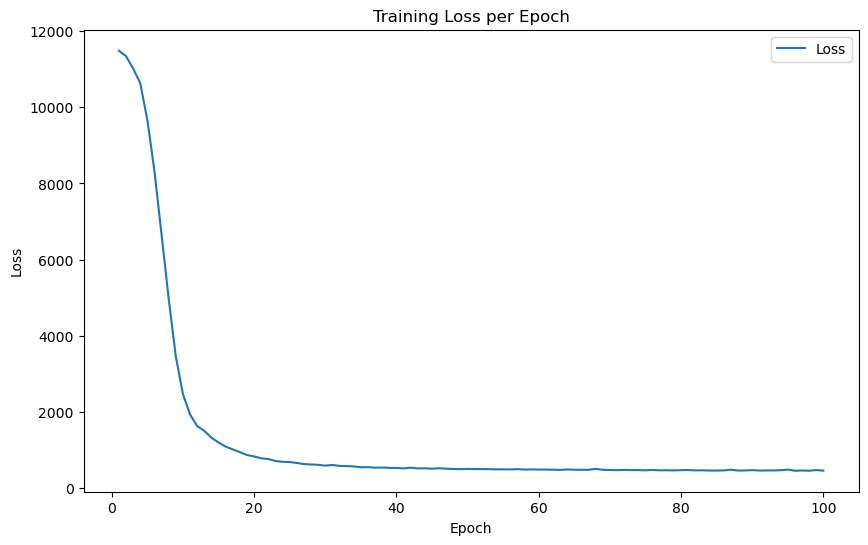

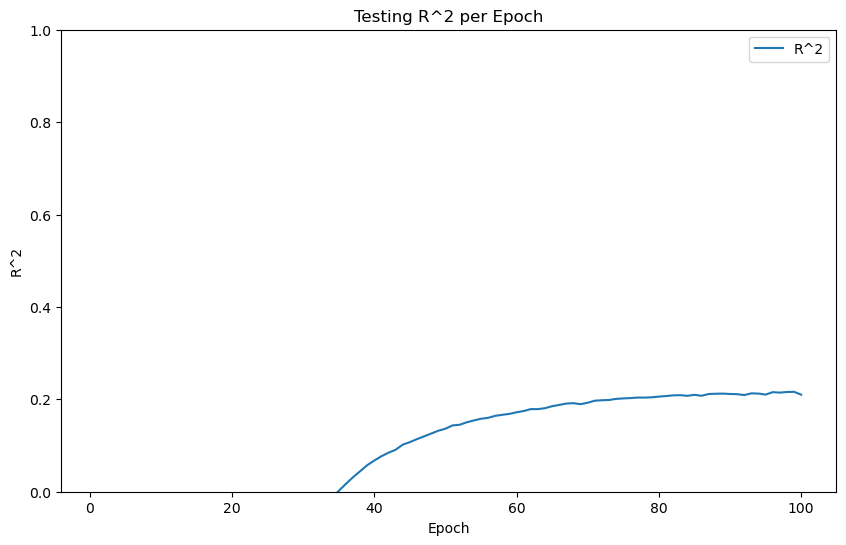

In [10]:
# run model
utils.run_model(100, train_loader, test_loader, model, loss_fn, optimizer, device)

In [11]:
# save model
torch.save(model.state_dict(), "models/model_2.pth")
print("Saved PyTorch Model State to 'model_2.pth' in 'models' folder")

Saved PyTorch Model State to 'model_2.pth' in 'models' folder
